In [3]:
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [7]:
%matplotlib inline

import keras
from keras.models import model_from_json
from keras.models import Model
import h5py
import numpy as np
from deeplift import dinuc_shuffle
from matplotlib import pyplot as plt
import sys
from deeplift.visualization import viz_sequence
import scipy
from scipy import stats


argmax_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
def onehot_to_seq(onehot):
    seq = "".join([argmax_to_letter[x] for x in np.argmax(onehot,axis=-1)])
    return seq

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

def compare_methods(method_1_name, method_2_name, score_lookup):
    method_1_scores=score_lookup[method_1_name]
    method_2_scores=score_lookup[method_2_name]
    differences = method_2_scores-method_1_scores
    sorted_differences = sorted(differences,key=lambda x:np.abs(x))
    #print(sorted_differences)
    positive_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] > 0])
    negative_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] < 0])
    wilcoxon_result = scipy.stats.wilcoxon(differences)
    if (wilcoxon_result.pvalue > 0.05):
        symbol = "~"
    else:
        symbol = ">"
    
    if (negative_ranks < positive_ranks):
        print(method_2_name," "+symbol+" ",method_1_name,"pval",wilcoxon_result.pvalue)
        plt.scatter(method_1_scores, method_2_scores, alpha=0.3)
        plt.plot([np.min(method_1_scores), np.max(method_1_scores)],
                 [np.min(method_1_scores), np.max(method_1_scores)],
                 color="black")
        plt.xlabel(method_1_name)
        plt.ylabel(method_2_name)     
    else:
        print(method_1_name," "+symbol+" ",method_2_name,"pval",wilcoxon_result.pvalue)
        plt.scatter(method_2_scores, method_1_scores, alpha=0.3)
        plt.plot([np.min(method_2_scores), np.max(method_2_scores)],
                 [np.min(method_2_scores), np.max(method_2_scores)],
                 color="black")
        plt.xlabel(method_2_name)
        plt.ylabel(method_1_name)
    plt.show()
    



###########
On model prefix HepG2/record_1_model_txak1 
############

avg_diff_meansubbed scores_ism 25.201633 num negative: 12
avg_diff_zerod scores_ism 28.568419 num negative: 23

avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 25.775755 num negative: 11
avg_diff_zerod scores_deeplift_rescale_dinucshuff 30.70627 num negative: 22

avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 24.863089 num negative: 12
avg_diff_zerod scores_deeplift_genomicsdefault_dinucshuff 29.696964 num negative: 23

avg_diff_meansubbed scores_integrated_grad20_dinucshuff 20.699537 num negative: 48
avg_diff_zerod scores_integrated_grad20_dinucshuff 30.358892 num negative: 14

avg_diff_meansubbed scores_grad_times_inp_flatref 21.413277 num negative: 29
avg_diff_zerod scores_grad_times_inp_flatref 26.416868 num negative: 47

avg_diff_meansubbed scores_integrated_grad20_avgposref 20.79784 num negative: 28
avg_diff_zerod scores_integrated_grad20_avgposref 30.25735 num negative: 16

avg_diff_me

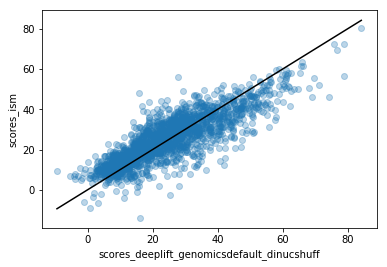

scores_deeplift_rescale_dinucshuff  ~  scores_ism pval 0.22473310451097617


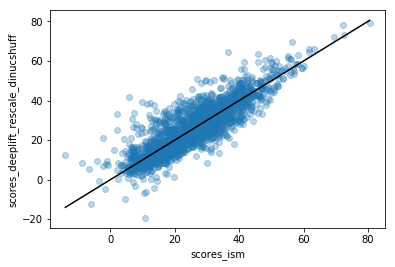

scores_ism  >  scores_integrated_grad20_dinucshuff pval 3.27225116534757e-110


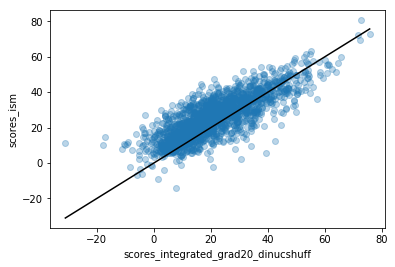

scores_ism  >  scores_grad_times_inp_flatref pval 5.161891191954645e-149


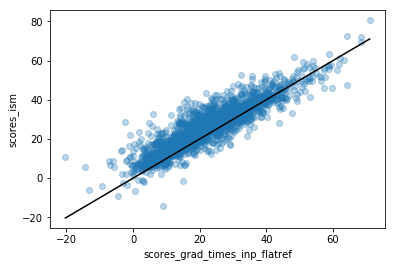

scores_deeplift_genomicsdefault_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 1.859336890160208e-120


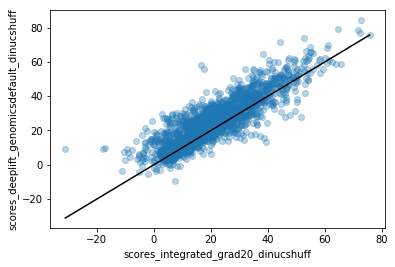

scores_deeplift_genomicsdefault_dinucshuff  >  scores_grad_times_inp_flatref pval 4.0344646201252404e-80


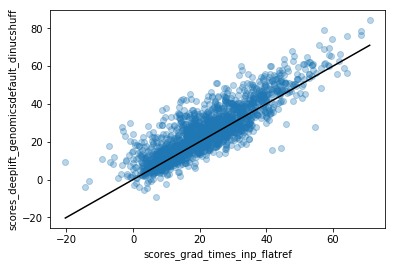

scores_deeplift_rescale_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 5.615159033739554e-184


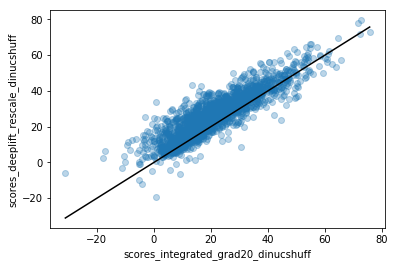

scores_deeplift_rescale_dinucshuff  >  scores_grad_times_inp_flatref pval 3.405438185679337e-148


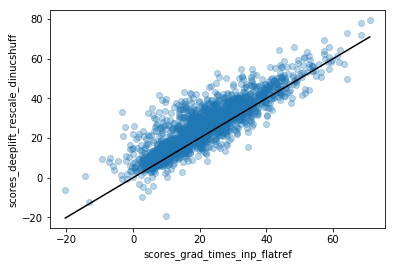

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_genomicsdefault_dinucshuff pval 2.1904301073728859e-16


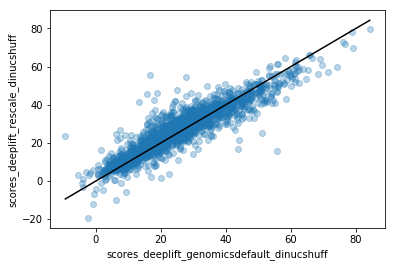

scores_grad_times_inp_flatref  >  scores_integrated_grad20_dinucshuff pval 3.5443813591356487e-06


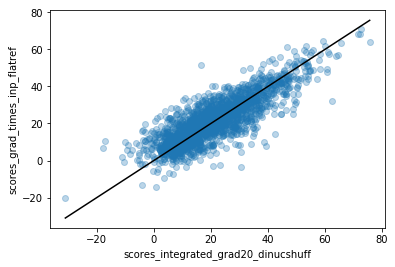

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad20_flatref pval 5.9695358327026425e-298


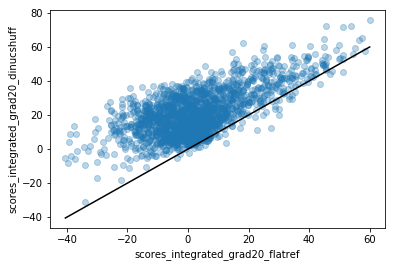

scores_integrated_grad20_dinucshuff  ~  scores_integrated_grad20_avgposref pval 0.34882276600398254


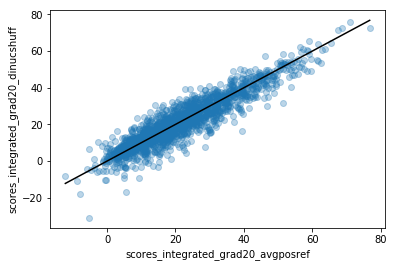

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_flatref pval 6.467845668653814e-245


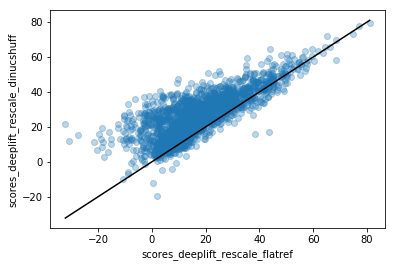

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_avgposref pval 2.6861065142782973e-208


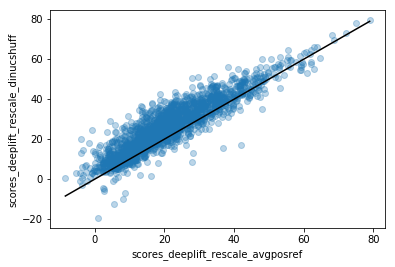

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_flatref pval 2.779205404702084e-262


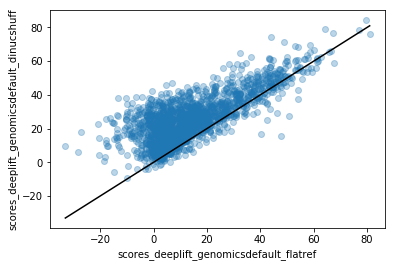

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_avgposref pval 3.0553488108877737e-239


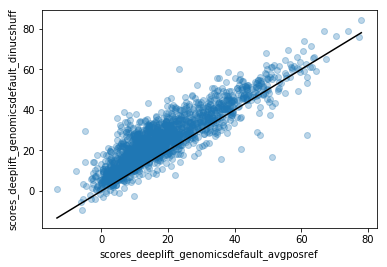

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad2_dinucshuff pval 1.1850090650193785e-11


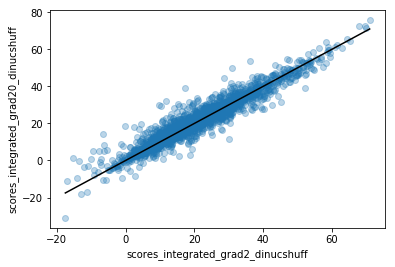

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad10_dinucshuff pval 0.0009472738871191838


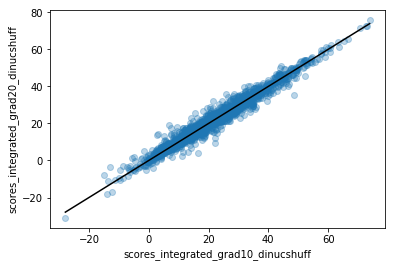



###########
On model prefix GM12878/record_1_model_8E0g9 
############

avg_diff_meansubbed scores_ism 24.856407 num negative: 0
avg_diff_zerod scores_ism 26.651463 num negative: 1

avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 24.233849 num negative: 5
avg_diff_zerod scores_deeplift_rescale_dinucshuff 26.359766 num negative: 9

avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 24.240099 num negative: 5
avg_diff_zerod scores_deeplift_genomicsdefault_dinucshuff 26.303276 num negative: 5

avg_diff_meansubbed scores_integrated_grad20_dinucshuff 23.015823 num negative: 3
avg_diff_zerod scores_integrated_grad20_dinucshuff 26.270706 num negative: 5

avg_diff_meansubbed scores_grad_times_inp_flatref 22.253693 num negative: 6
avg_diff_zerod scores_grad_times_inp_flatref 25.495567 num negative: 5

avg_diff_meansubbed scores_integrated_grad20_avgposref 22.421896 num negative: 1
avg_diff_zerod scores_integrated_grad20_avgposref 26.05454 num negative: 2

avg_diff_meansubbed

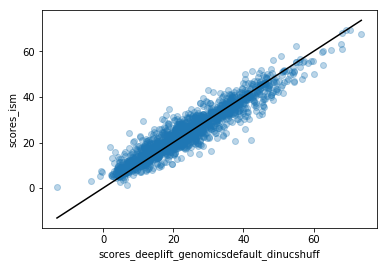

scores_ism  >  scores_deeplift_rescale_dinucshuff pval 3.2159421554693573e-10


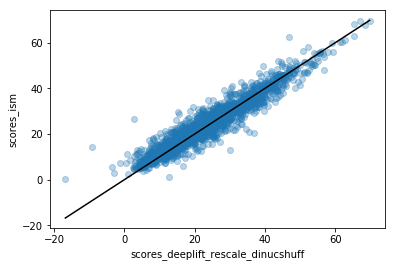

scores_ism  >  scores_integrated_grad20_dinucshuff pval 3.656470244117666e-66


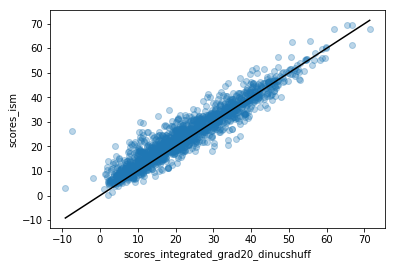

scores_ism  >  scores_grad_times_inp_flatref pval 1.986053323519196e-127


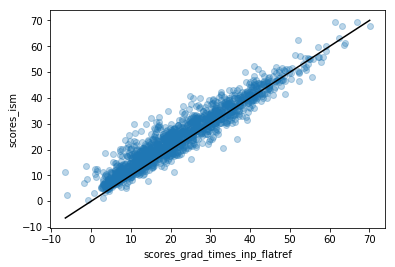

scores_deeplift_genomicsdefault_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 1.0070753536642748e-36


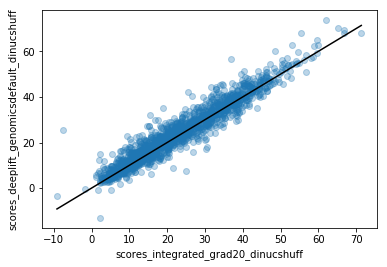

scores_deeplift_genomicsdefault_dinucshuff  >  scores_grad_times_inp_flatref pval 1.2088670988151644e-68


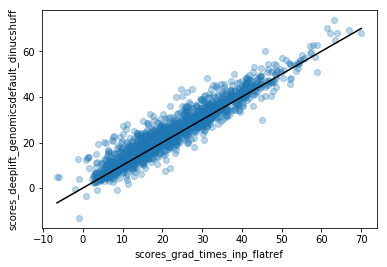

scores_deeplift_rescale_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 6.506442597679392e-41


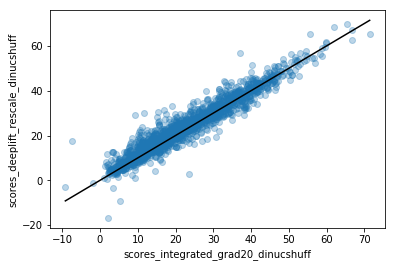

scores_deeplift_rescale_dinucshuff  >  scores_grad_times_inp_flatref pval 5.633173200806736e-85


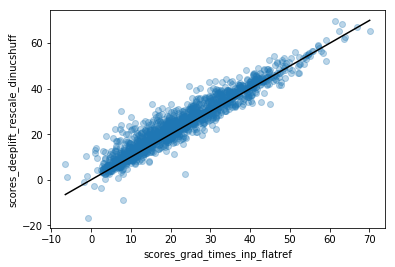

scores_deeplift_rescale_dinucshuff  ~  scores_deeplift_genomicsdefault_dinucshuff pval 0.5367754010708934


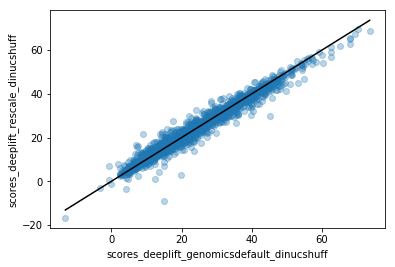

scores_integrated_grad20_dinucshuff  >  scores_grad_times_inp_flatref pval 9.521394908839273e-16


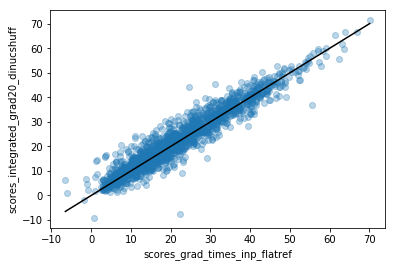

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad20_flatref pval 1.307510446744649e-17


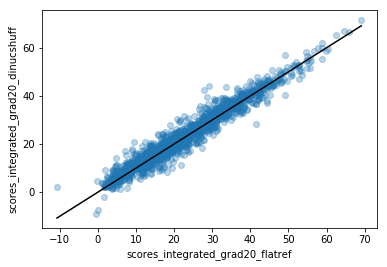

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad20_avgposref pval 1.5524110156037827e-18


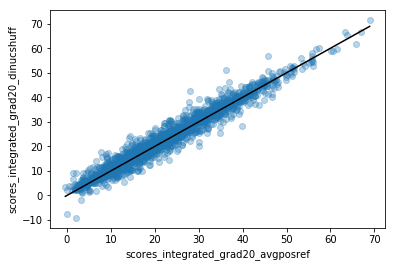

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_flatref pval 4.814440145026536e-161


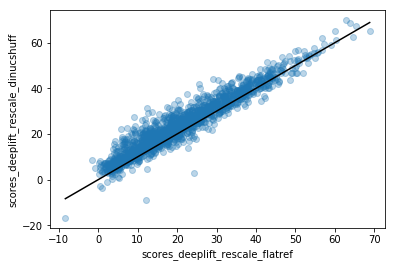

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_avgposref pval 2.2195475448754655e-119


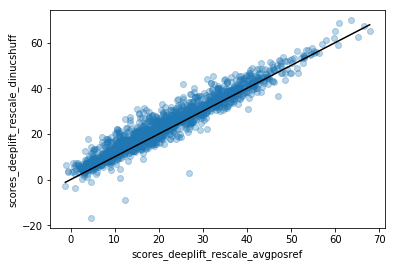

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_flatref pval 1.7246180541175958e-154


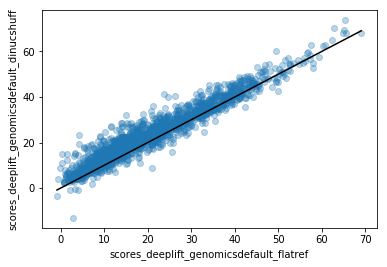

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_avgposref pval 3.557801386314898e-120


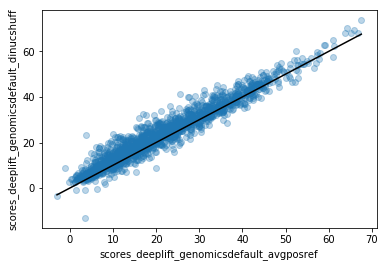

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad2_dinucshuff pval 1.814949768252037e-29


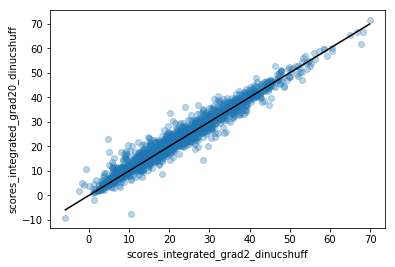

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad10_dinucshuff pval 1.626332068284925e-05


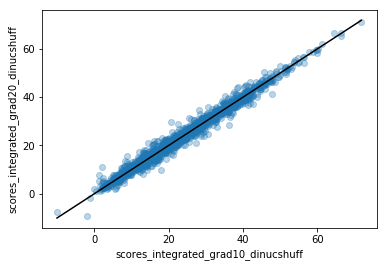



###########
On model prefix K562/record_1_model_YJQ5u 
############

avg_diff_meansubbed scores_ism 27.438152 num negative: 17
avg_diff_zerod scores_ism 28.634727 num negative: 36

avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 26.453192 num negative: 34
avg_diff_zerod scores_deeplift_rescale_dinucshuff 29.234299 num negative: 64

avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 26.496822 num negative: 22
avg_diff_zerod scores_deeplift_genomicsdefault_dinucshuff 28.967081 num negative: 38

avg_diff_meansubbed scores_integrated_grad20_dinucshuff 20.533875 num negative: 118
avg_diff_zerod scores_integrated_grad20_dinucshuff 30.971067 num negative: 61

avg_diff_meansubbed scores_grad_times_inp_flatref 22.794907 num negative: 60
avg_diff_zerod scores_grad_times_inp_flatref 25.963385 num negative: 69

avg_diff_meansubbed scores_integrated_grad20_avgposref 18.792097 num negative: 123
avg_diff_zerod scores_integrated_grad20_avgposref 29.245476 num negative: 59

avg_dif

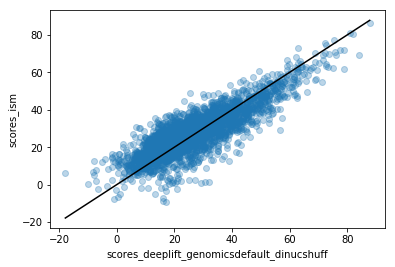

scores_ism  >  scores_deeplift_rescale_dinucshuff pval 2.774289080308824e-20


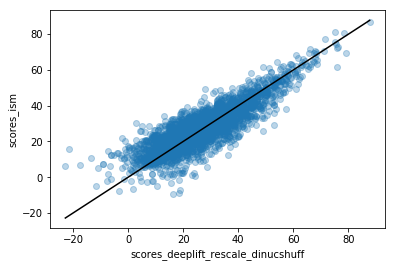

scores_ism  >  scores_integrated_grad20_dinucshuff pval 1.2185767716492227e-305


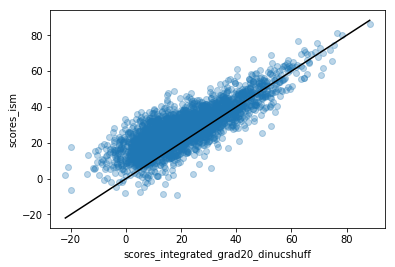

scores_ism  >  scores_grad_times_inp_flatref pval 2.3352587184156555e-281


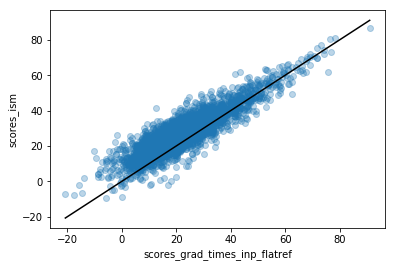

scores_deeplift_genomicsdefault_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 0.0


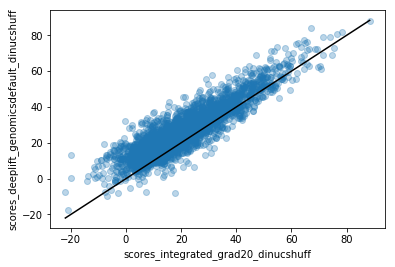

scores_deeplift_genomicsdefault_dinucshuff  >  scores_grad_times_inp_flatref pval 4.93230922890265e-162


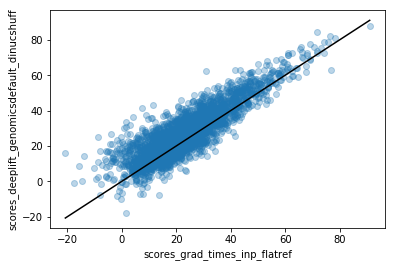

scores_deeplift_rescale_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 0.0


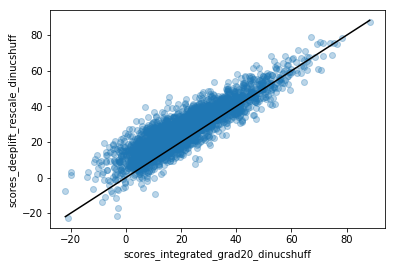

scores_deeplift_rescale_dinucshuff  >  scores_grad_times_inp_flatref pval 2.128064571386569e-170


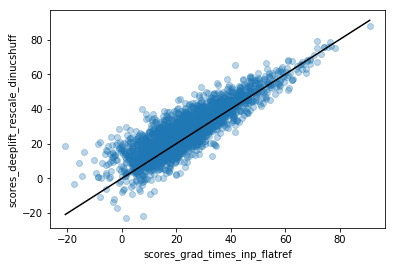

scores_deeplift_genomicsdefault_dinucshuff  ~  scores_deeplift_rescale_dinucshuff pval 0.6930025768683361


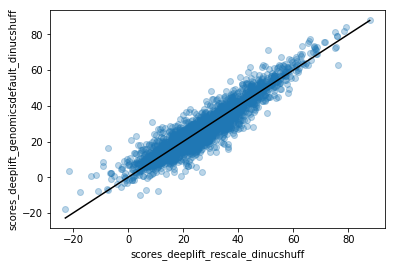

scores_grad_times_inp_flatref  >  scores_integrated_grad20_dinucshuff pval 3.145836076464836e-62


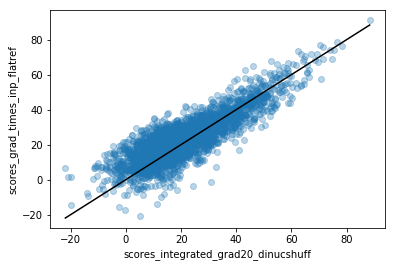

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad20_flatref pval 1.5388713495860403e-21


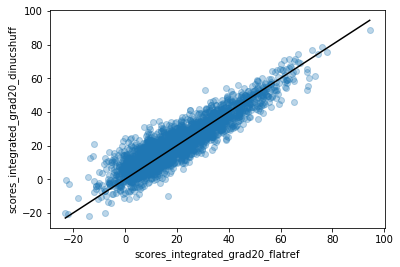

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad20_avgposref pval 2.2293282213012153e-76


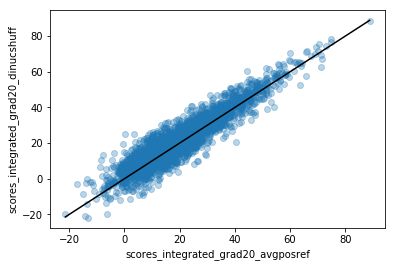

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_flatref pval 0.0


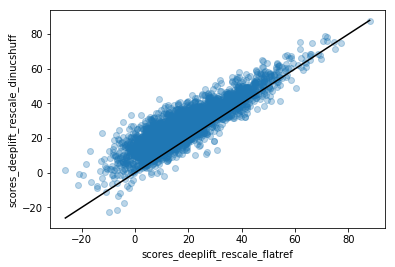

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_avgposref pval 0.0


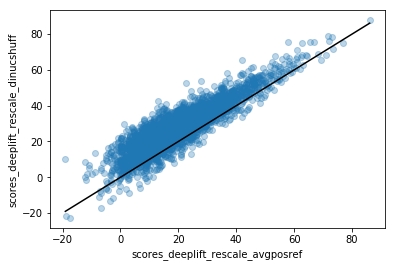

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_flatref pval 0.0


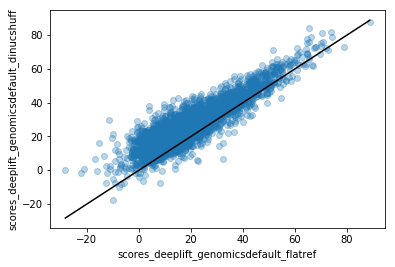

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_avgposref pval 0.0


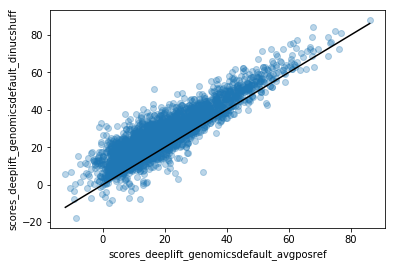

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad2_dinucshuff pval 1.979274285756893e-24


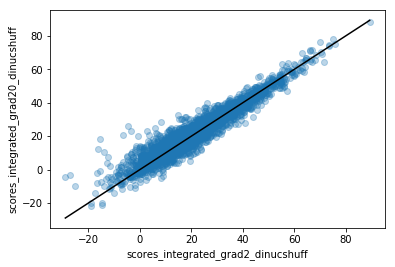

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad10_dinucshuff pval 4.851213182587851e-08


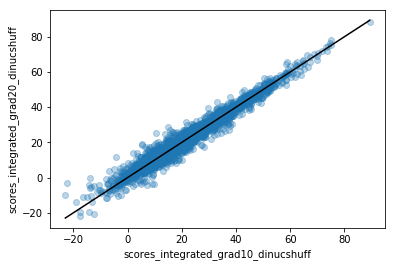



###########
On model prefix A549/record_1_model_xIIj6 
############

avg_diff_meansubbed scores_ism 23.283272 num negative: 29
avg_diff_zerod scores_ism 24.729376 num negative: 43

avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 25.193127 num negative: 37
avg_diff_zerod scores_deeplift_rescale_dinucshuff 26.861212 num negative: 67

avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 24.783466 num negative: 9
avg_diff_zerod scores_deeplift_genomicsdefault_dinucshuff 26.810694 num negative: 15

avg_diff_meansubbed scores_integrated_grad20_dinucshuff 25.449852 num negative: 26
avg_diff_zerod scores_integrated_grad20_dinucshuff 28.711952 num negative: 48

avg_diff_meansubbed scores_grad_times_inp_flatref 20.0004 num negative: 66
avg_diff_zerod scores_grad_times_inp_flatref 22.19748 num negative: 90

avg_diff_meansubbed scores_integrated_grad20_avgposref 23.390701 num negative: 52
avg_diff_zerod scores_integrated_grad20_avgposref 28.127575 num negative: 71

avg_diff_mean

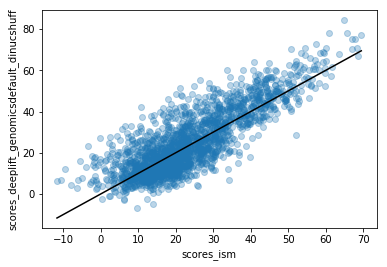

scores_deeplift_rescale_dinucshuff  >  scores_ism pval 1.166200386926016e-30


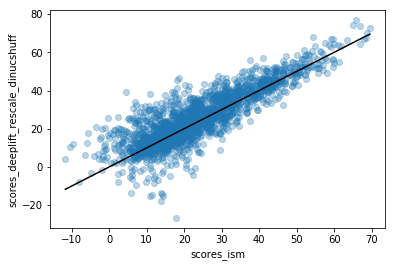

scores_integrated_grad20_dinucshuff  >  scores_ism pval 9.333515317359973e-29


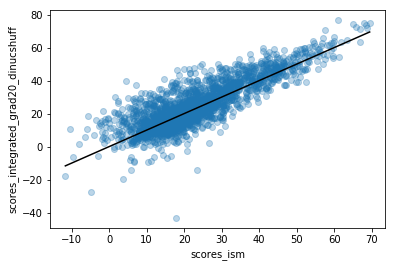

scores_ism  >  scores_grad_times_inp_flatref pval 2.8591523109729117e-131


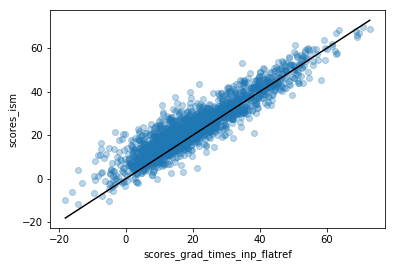

scores_integrated_grad20_dinucshuff  >  scores_deeplift_genomicsdefault_dinucshuff pval 1.526465111517166e-10


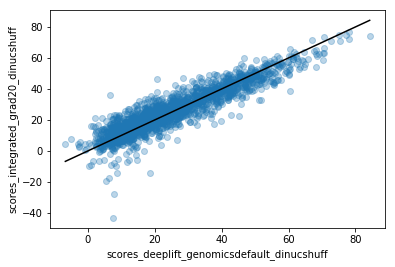

scores_deeplift_genomicsdefault_dinucshuff  >  scores_grad_times_inp_flatref pval 4.101899277164276e-124


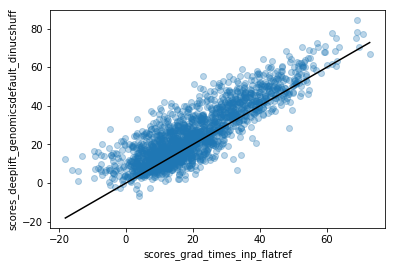

scores_integrated_grad20_dinucshuff  >  scores_deeplift_rescale_dinucshuff pval 0.033832963339573155


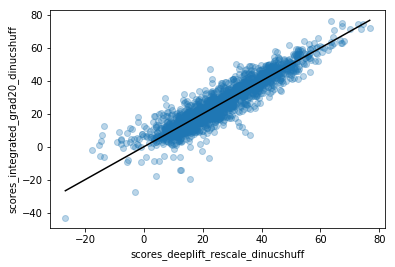

scores_deeplift_rescale_dinucshuff  >  scores_grad_times_inp_flatref pval 1.6961103547645793e-180


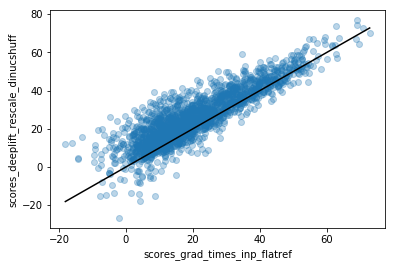

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_genomicsdefault_dinucshuff pval 2.4753468390674077e-06


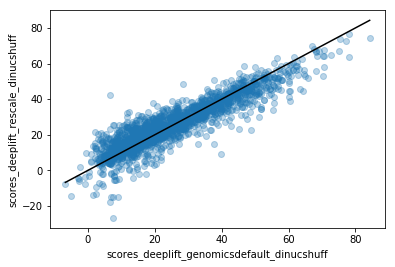

scores_integrated_grad20_dinucshuff  >  scores_grad_times_inp_flatref pval 5.719487052935009e-174


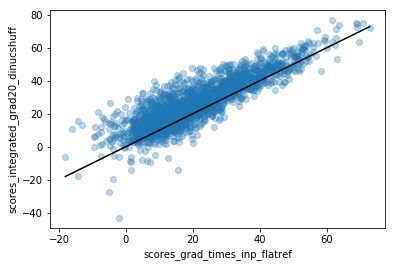

scores_integrated_grad20_flatref  >  scores_integrated_grad20_dinucshuff pval 5.1722083209163787e-23


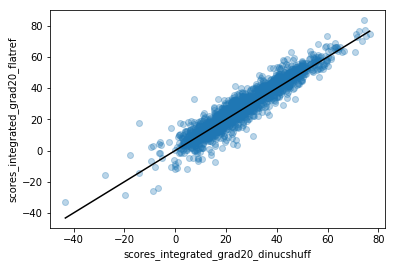

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad20_avgposref pval 7.472691166231118e-68


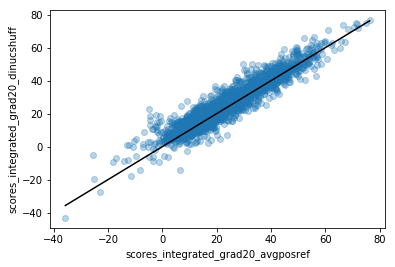

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_flatref pval 4.3844306050312455e-24


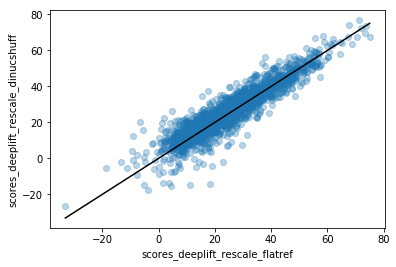

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_avgposref pval 8.697971243002672e-81


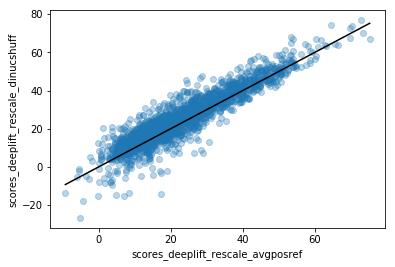

scores_deeplift_genomicsdefault_dinucshuff  ~  scores_deeplift_genomicsdefault_flatref pval 0.3725519016504797


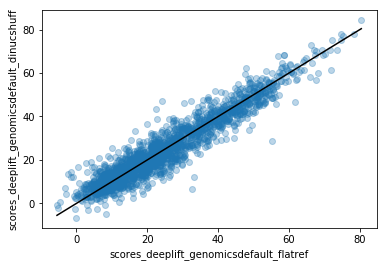

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_avgposref pval 4.810870853533149e-68


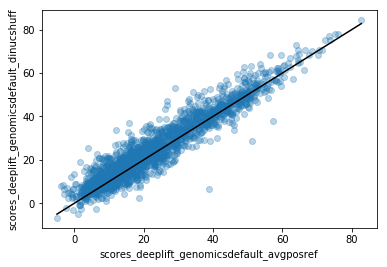

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad2_dinucshuff pval 1.0636165230386805e-45


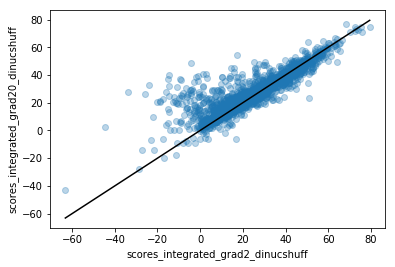

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad10_dinucshuff pval 9.364743587417184e-14


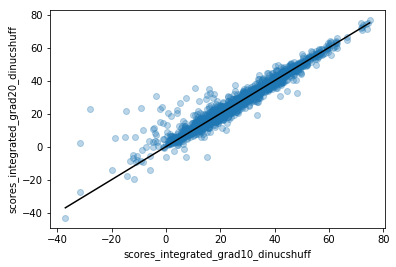



###########
On model prefix MCF-7/record_1_model_HICYK 
############

avg_diff_meansubbed scores_ism 30.62473 num negative: 8
avg_diff_zerod scores_ism 37.64013 num negative: 6

avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 30.583391 num negative: 12
avg_diff_zerod scores_deeplift_rescale_dinucshuff 36.92474 num negative: 17

avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 30.17892 num negative: 8
avg_diff_zerod scores_deeplift_genomicsdefault_dinucshuff 36.064075 num negative: 8

avg_diff_meansubbed scores_integrated_grad20_dinucshuff 24.81703 num negative: 57
avg_diff_zerod scores_integrated_grad20_dinucshuff 38.93432 num negative: 9

avg_diff_meansubbed scores_grad_times_inp_flatref 27.643732 num negative: 20
avg_diff_zerod scores_grad_times_inp_flatref 34.102722 num negative: 15

avg_diff_meansubbed scores_integrated_grad20_avgposref 24.557264 num negative: 54
avg_diff_zerod scores_integrated_grad20_avgposref 39.039917 num negative: 6

avg_diff_meansubbed 

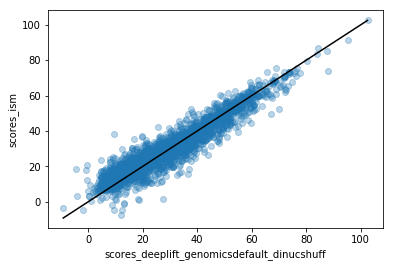

scores_ism  ~  scores_deeplift_rescale_dinucshuff pval 0.4140599270910529


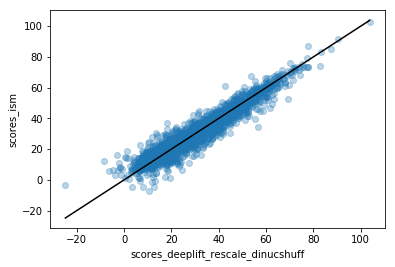

scores_ism  >  scores_integrated_grad20_dinucshuff pval 1.9674871350244172e-246


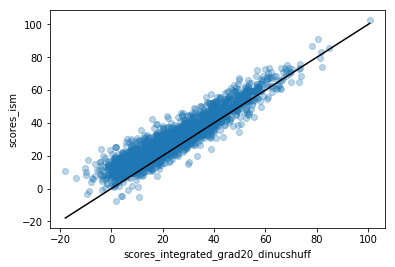

scores_ism  >  scores_grad_times_inp_flatref pval 7.0046701338941715e-155


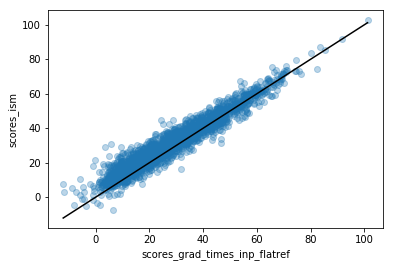

scores_deeplift_genomicsdefault_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 2.4604850025479785e-252


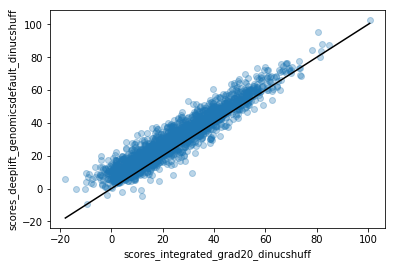

scores_deeplift_genomicsdefault_dinucshuff  >  scores_grad_times_inp_flatref pval 3.74348635568624e-93


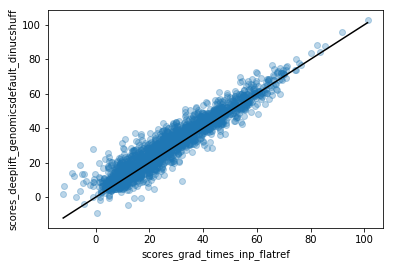

scores_deeplift_rescale_dinucshuff  >  scores_integrated_grad20_dinucshuff pval 7.074155382172065e-273


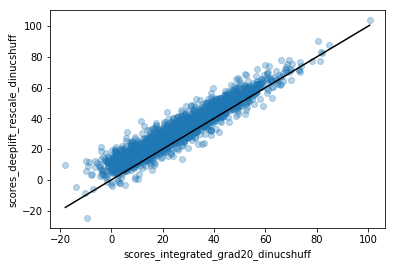

scores_deeplift_rescale_dinucshuff  >  scores_grad_times_inp_flatref pval 3.5802435139317837e-140


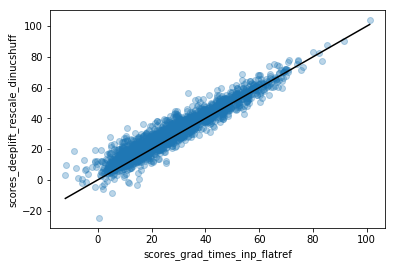

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_genomicsdefault_dinucshuff pval 6.997295179245009e-07


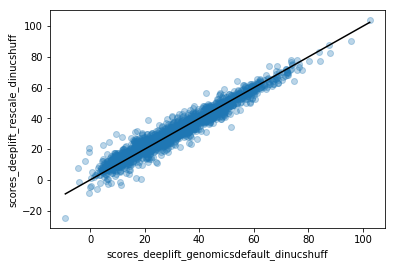

scores_grad_times_inp_flatref  >  scores_integrated_grad20_dinucshuff pval 1.2112160603175255e-107


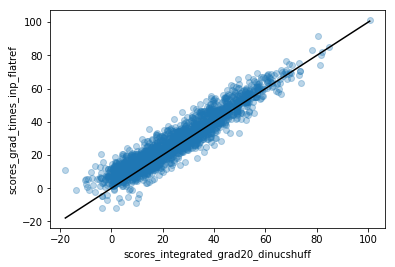

scores_integrated_grad20_flatref  >  scores_integrated_grad20_dinucshuff pval 3.484583482911624e-14


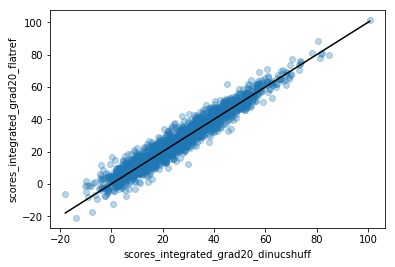

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad20_avgposref pval 0.00039141514621616325


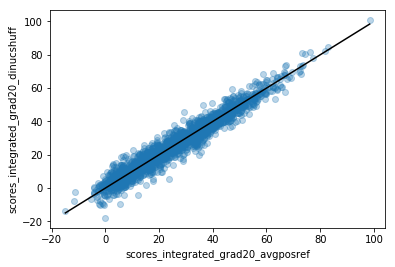

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_flatref pval 6.775220714031632e-308


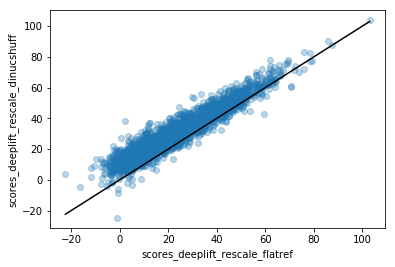

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_rescale_avgposref pval 0.0


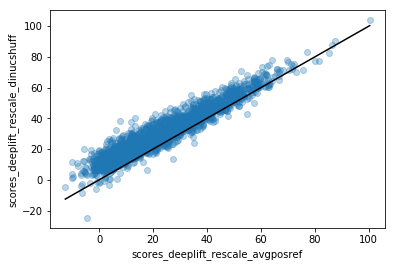

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_flatref pval 1.0007688115041617e-248


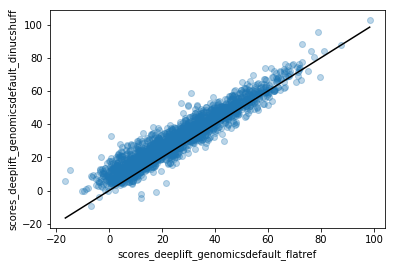

scores_deeplift_genomicsdefault_dinucshuff  >  scores_deeplift_genomicsdefault_avgposref pval 2.890421270301747e-268


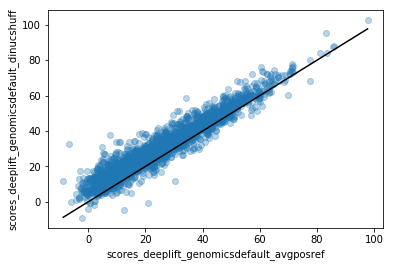

scores_integrated_grad20_dinucshuff  >  scores_integrated_grad2_dinucshuff pval 3.2561555975471075e-20


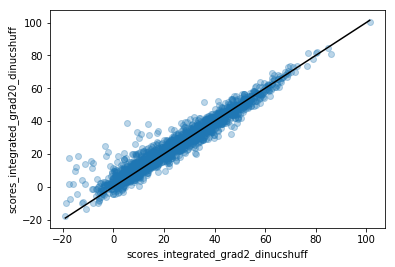

scores_integrated_grad20_dinucshuff  ~  scores_integrated_grad10_dinucshuff pval 0.3468613032098319


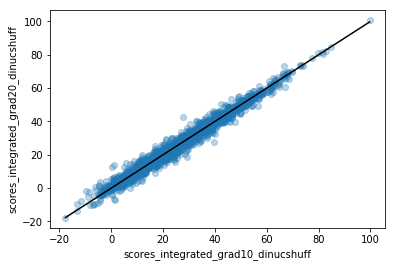

In [8]:

#dan preinit
#model_prefix = "record_21_model_NZqHC"
#model_prefix = "record_20_model_QFbAM"

model_prefixes_and_folders = [
    ("record_1_model_txak1", "HepG2"),
    ("record_1_model_8E0g9", "GM12878"),
    ("record_1_model_YJQ5u", "K562"),
    ("record_1_model_xIIj6", "A549"),
    ("record_1_model_HICYK", "MCF-7"),
]


#trained from scratch
#model_prefix = "record_15_model_REDP7"

#fcfromscratch
#model_prefix = "record_25_model_Fq78N"
#imp_scores_folder = "imp_scores/fcfromscratch-randinporder"

model_folder_to_subbed_diffs_lookup = {}
model_folder_to_zerod_diffs_lookup = {}

for model_prefix,folder in model_prefixes_and_folders:
    print("\n\n###########\nOn model prefix",folder+"/"+model_prefix,"\n############")
    
    model_weights = folder+"/model_files/"+model_prefix+"_modelWeights.h5"
    model_json = folder+"/model_files/"+model_prefix+"_modelJson.json"

    keras_model = model_from_json(open(model_json).read())
    keras_model.load_weights(model_weights)

    preact_model = Model(inputs=keras_model.input,
                         outputs=keras_model.layers[-2].output)

    imp_scores_fh = h5py.File(folder+"/imp_scores_"+model_prefix+".h5", "r")
    onehot_seq = np.array(imp_scores_fh['onehot'])
    orig_preds = preact_model.predict(onehot_seq).squeeze()

    seqs = [onehot_to_seq(x) for x in onehot_seq]
    shuffled_onehot_seqs = []
    num_shuffles_to_make = 10
    for i in range(num_shuffles_to_make):
        shuffled_onehot_seqs.append(np.array(
                [one_hot_encode_along_channel_axis(dinuc_shuffle.dinuc_shuffle(x)) for x in seqs]))
    

    #######Score things
    method_to_zerod_diffs = {}
    method_to_subbed_diffs = {}

    percentile = 80

    scoring_methods = [
        'scores_ism',
        'scores_deeplift_rescale_dinucshuff',
        'scores_deeplift_genomicsdefault_dinucshuff',
        'scores_integrated_grad20_dinucshuff',
        'scores_grad_times_inp_flatref',

        'scores_integrated_grad20_avgposref',
        'scores_deeplift_rescale_avgposref',
        'scores_deeplift_genomicsdefault_avgposref',
        'scores_integrated_grad20_flatref',
        'scores_deeplift_rescale_flatref',
        'scores_deeplift_genomicsdefault_flatref',

        'scores_integrated_grad10_dinucshuff',
        'scores_integrated_grad2_dinucshuff',
        'scores_integrated_grad5_dinucshuff',     
    ]

    for method in scoring_methods:
        #print(method)
        sys.stdout.flush()
        scores = np.array(imp_scores_fh[method])
        central_scores = scores[:,350:650]

        #for each example, zero out the top 10% of scores

        #to_zero = list(zip(*np.nonzero(central_scores > np.percentile(central_scores,percentile))))
        #print(len(to_zero))

        to_zero = [
            (i,x) for i,ex_central_scores in enumerate(central_scores)
             for x in np.nonzero(ex_central_scores >
                                 np.percentile(ex_central_scores,percentile))[0]
        ]
        #print(len(to_zero))

        zerod_inputs = np.array(onehot_seq)
        for example_idx, col_idx in to_zero:
            zerod_inputs[example_idx,350+col_idx] = 0.25

        subbed_inputs_sets = []
        for i in range(num_shuffles_to_make):
            subbed_inputs = np.array(onehot_seq)
            for example_idx, col_idx in to_zero:
                subbed_inputs[example_idx,350+col_idx] = shuffled_onehot_seqs[i][example_idx,350+col_idx]
            subbed_inputs_sets.append(subbed_inputs)
        mean_subbed_preds = np.mean(np.array([preact_model.predict(x).squeeze() for x in subbed_inputs_sets]),axis=0)
        method_to_subbed_diffs[method] = orig_preds-mean_subbed_preds
        print("\navg_diff_meansubbed",method,np.mean(orig_preds-mean_subbed_preds),"num negative:",np.sum(orig_preds-mean_subbed_preds < 0))

        #viz_sequence.plot_weights((onehot_seq[0]*scores[0][:,None])[350:650])
        #viz_sequence.plot_weights((altered_inputs[0]*scores[0][:,None])[350:650])

        zerod_preds = np.squeeze(preact_model.predict(zerod_inputs))
        method_to_zerod_diffs[method] = orig_preds-zerod_preds
        print("avg_diff_zerod",method,np.mean(orig_preds-zerod_preds),"num negative:",np.sum(orig_preds-zerod_preds < 0))

        sys.stdout.flush()
    
    ########Run comparisons
    
    model_folder_to_subbed_diffs_lookup[folder] = method_to_subbed_diffs
    model_folder_to_zerod_diffs_lookup[folder] = method_to_zerod_diffs

    diffs_lookup = method_to_subbed_diffs    

    #print("Compare to ISM")
    print("\n##Comparisons##\n")

    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_grad_times_inp_flatref",
                    score_lookup=diffs_lookup)

    #print("Comparisons to DeepLIFT")

    compare_methods(method_1_name="scores_integrated_grad20_dinucshuff",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_grad_times_inp_flatref",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)
    
    compare_methods(method_1_name="scores_integrated_grad20_dinucshuff",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_grad_times_inp_flatref",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)

    #print("Deeplift revealcancel vs rescale")

    compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)

    #print("Grad times inp vs intgrad")
    compare_methods(method_1_name="scores_grad_times_inp_flatref",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)
    
    #print("Compare references")
    compare_methods(method_1_name="scores_integrated_grad20_flatref",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_integrated_grad20_avgposref",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_deeplift_rescale_flatref",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_deeplift_rescale_avgposref",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_deeplift_genomicsdefault_flatref",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_deeplift_genomicsdefault_avgposref",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)

    #print("Compare different intgrads)
    compare_methods(method_1_name="scores_integrated_grad2_dinucshuff",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_integrated_grad10_dinucshuff",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)


In [28]:
def vis_examples_favoring_method_1(method_1_name, method_2_name,
                                   methods_to_plot,
                                   perf_lookup, imp_scores_fh,
                                   onehot_seq,
                                   num_to_plot=3):
    method_1_perfs = perf_lookup[method_1_name]
    method_2_perfs = perf_lookup[method_2_name]
    method_1_minus_method_2_perfs = method_1_perfs - method_2_perfs
    top_method_1_examples = [x[0] for x in sorted(enumerate(method_1_minus_method_2_perfs),
                                   key=lambda x: -x[1]) if x[1] > 0]
    
    method_1_scores = np.array(imp_scores_fh[method_1_name])
    method_2_scores = np.array(imp_scores_fh[method_2_name])
    
    print(len(top_method_1_examples))
    for ex_id in top_method_1_examples[::int(len(top_method_1_examples)/num_to_plot)]:
        for method_to_plot in methods_to_plot:
            print(method_to_plot+" diff",perf_lookup[method_to_plot][ex_id])
            print(method_to_plot+" imp scores")
            viz_sequence.plot_weights((onehot_seq[ex_id]*imp_scores_fh[method_to_plot][ex_id][:,None])[350:650],
                                      subticks_frequency=20)

1160
scores_ism diff 4.4483023
scores_ism imp scores


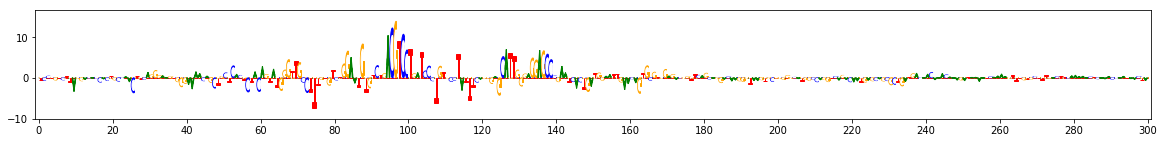

scores_deeplift_rescale_dinucshuff diff 39.329273
scores_deeplift_rescale_dinucshuff imp scores


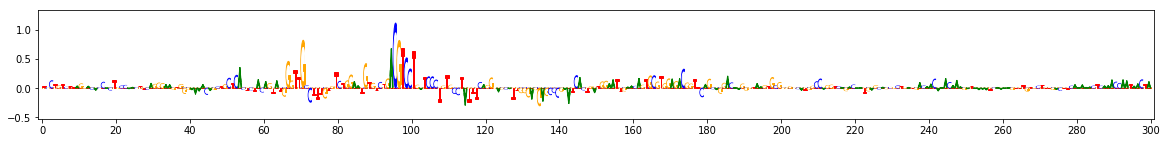

scores_integrated_grad20_dinucshuff diff 39.938866
scores_integrated_grad20_dinucshuff imp scores


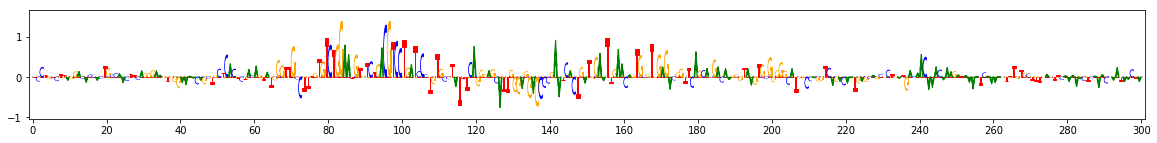

scores_ism diff 51.850246
scores_ism imp scores


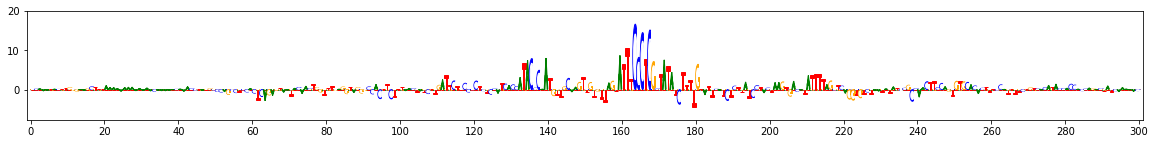

scores_deeplift_rescale_dinucshuff diff 61.13485
scores_deeplift_rescale_dinucshuff imp scores


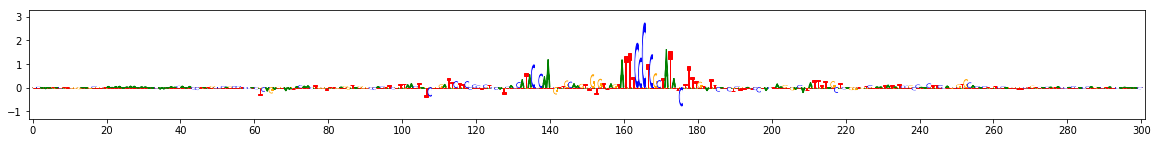

scores_integrated_grad20_dinucshuff diff 59.776833
scores_integrated_grad20_dinucshuff imp scores


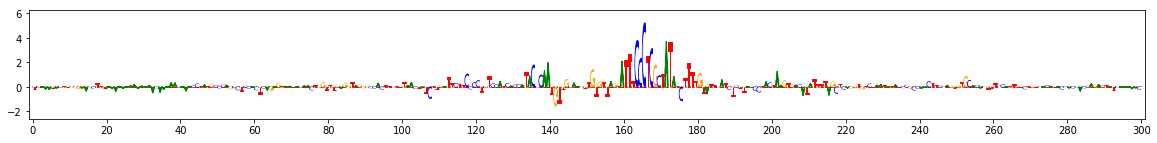

scores_ism diff 15.73529
scores_ism imp scores


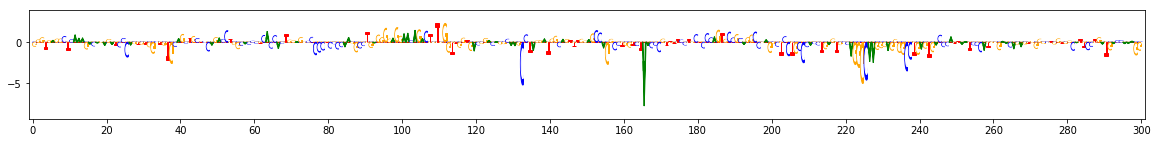

scores_deeplift_rescale_dinucshuff diff 16.331589
scores_deeplift_rescale_dinucshuff imp scores


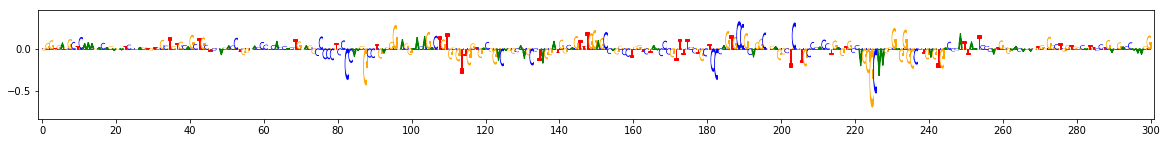

scores_integrated_grad20_dinucshuff diff 19.199173
scores_integrated_grad20_dinucshuff imp scores


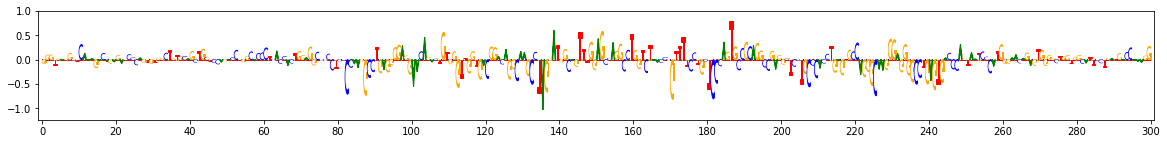

scores_ism diff 41.816833
scores_ism imp scores


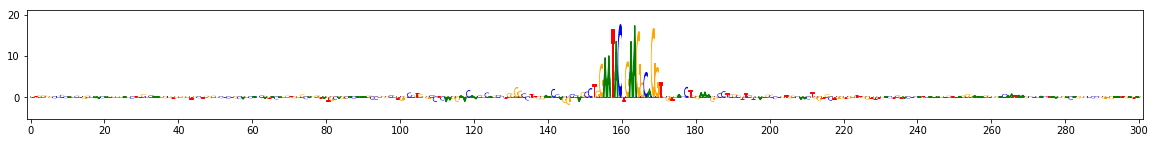

scores_deeplift_rescale_dinucshuff diff 46.264557
scores_deeplift_rescale_dinucshuff imp scores


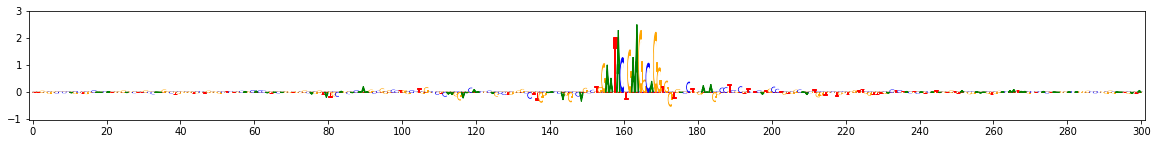

scores_integrated_grad20_dinucshuff diff 41.836548
scores_integrated_grad20_dinucshuff imp scores


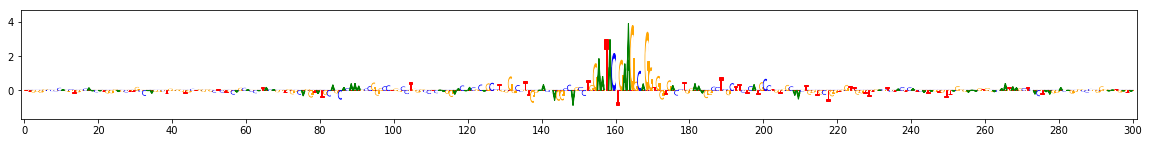

In [29]:
vis_examples_favoring_method_1(method_1_name="scores_integrated_grad20_dinucshuff",
                               method_2_name="scores_ism",
                               methods_to_plot=["scores_ism",
                                                #"scores_grad_times_inp_flatref",
                                                #"scores_deeplift_genomicsdefault_dinucshuff",
                                                "scores_deeplift_rescale_dinucshuff",
                                                "scores_integrated_grad20_dinucshuff"],
                               perf_lookup=model_folder_to_subbed_diffs_lookup["A549"],
                               imp_scores_fh=h5py.File("A549/imp_scores_record_1_model_xIIj6.h5", "r"),
                               onehot_seq=onehot_seq)